<a href="https://colab.research.google.com/github/jbloewencolon/Psychedelic-Trip-Generator/blob/main/LDA_and_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import re
import xgboost as xgb
import pickle
import tensorflow as tf
import itertools
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec, LdaModel, CoherenceModel
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.corpora import Dictionary
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tf.config.list_physical_devices('GPU')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/processed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67516 entries, 0 to 67515
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        67516 non-null  int64  
 1   title             67516 non-null  object 
 2   drug              67516 non-null  object 
 3   dosage            67516 non-null  object 
 4   delivery          67516 non-null  object 
 5   weight            67516 non-null  float64
 6   year              67516 non-null  int64  
 7   gender            67516 non-null  object 
 8   report            67516 non-null  object 
 9   processed_report  67516 non-null  object 
 10  mixed             67516 non-null  int64  
 11  drug_category     67516 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 6.2+ MB


In [29]:
df['processed_report'].head()

0    [['i', 'had', 'taken', 'ecstasy', 'once', 'bef...
1    [['it', 'all', 'started', 'at', 'about', '600a...
2    [['introduction', '', 'i', 'am', 'not', 'just'...
3    [['800', 'eat', '160', 'mg', 'of', 'butylone',...
4    [['due', 'to', 'the', 'recent', 'lack', 'of', ...
Name: processed_report, dtype: object

In [33]:
from ast import literal_eval

# Convert string representations of lists into actual lists
df['processed_report'] = df['processed_report'].apply(literal_eval)

# Now flatten the lists
df['processed_report'] = df['processed_report'].apply(lambda x: [word for sublist in x for word in sublist])

# Verify the conversion
print(type(df['processed_report'].iloc[0]))


<class 'list'>


In [26]:
# Function to convert a report into a vector
def report_to_vector(report, model):
    report_vec = []
    numw = 0
    for word in report:
        try:
            if numw == 0:
                report_vec = model.wv[word]
            else:
                report_vec = np.add(report_vec, model.wv[word])
            numw+=1
        except:
            pass
    return np.asarray(report_vec) / numw if numw != 0 else np.zeros(model.vector_size)

In [27]:
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.size = model.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([report_to_vector(report, self.model) for report in X])

In [34]:
# Tokenize the reports
#tokenized_reports = df['processed_report'].apply(simple_preprocess)

# Train a Word2Vec model
word2vec = Word2Vec(sentences=df['processed_report'], vector_size=100, window=5, min_count=5, workers=4)

In [11]:
# Define the file paths in your Google Drive where you want to save the pickle files
word2vec_model_file_path = '/content/drive/MyDrive/Colab Notebooks/Data/word2vec_model.pkl'
word2vec_vectorizer_file_path = '/content/drive/MyDrive/Colab Notebooks/Data/word2vec_vectorizer.pkl'
transformed_reports_file_path = '/content/drive/MyDrive/Colab Notebooks/Data/transformed_reports.pkl'

In [35]:
# Pickle the Word2Vec model (if you need to save the trained model)
with open(word2vec_model_file_path, 'wb') as f:
    pickle.dump(word2vec, f)

# Define feature extractor
vectorizer = Word2VecVectorizer(word2vec)

# Pickle the Word2VecVectorizer (if you need to save the vectorizer)
with open(word2vec_vectorizer_file_path, 'wb') as f:
    pickle.dump(vectorizer, f)

# Convert reports into vectors
X = vectorizer.transform(df['processed_report'].tolist())

# Pickle the transformed reports
with open(transformed_reports_file_path, 'wb') as f:
    pickle.dump(X, f)

In [39]:
# Load the Word2Vec model (if you have a saved model and you don't want to retrain)
with open(word2vec_model_file_path, 'rb') as f:
    loaded_word2vec = pickle.load(f)

# Load the Word2VecVectorizer (if you have a saved vectorizer)
with open(word2vec_vectorizer_file_path, 'rb') as f:
    loaded_vectorizer = pickle.load(f)

  # Load the transformed reports
with open(transformed_reports_file_path, 'rb') as f:
    X = pickle.load(f)

In [40]:
sample_reports = df['processed_report'].head(5)
sample_vectors = sample_reports.apply(lambda report: vectorizer.transform([report])).tolist()
for vector in sample_vectors:
    print(vector)

[[-0.40629327 -0.6844462   0.24885866 -0.24631184 -0.29945773 -0.6652727
   0.2543828   0.20026593  0.4175587  -0.5429801   0.04529489  0.8750824
   1.0377519  -0.587108    0.0309272   1.1814868  -1.2008426   0.39311752
  -0.11491086  0.11601011 -0.8095214  -0.7192577  -0.15760842  1.3560976
  -0.6919136   0.28093925  0.7557374   0.1999047  -0.4843487  -0.13913463
  -0.4187612   0.2883267  -0.12557362 -0.22749317 -0.16222656  0.9965233
   0.0090137   0.5212824  -0.3225415   0.8218316   0.66458267  0.3443764
  -0.7646323   0.08059596  0.7889484  -1.1687185   0.28060657  0.4120859
   0.4573179  -1.1768297  -0.7631931   0.20747797  0.45299128  0.31361213
   0.37322024  0.9603304  -1.2037654  -0.33190233  0.18590298 -0.40497527
  -0.12328833 -0.6387308   0.49704832  0.42304114  0.31244972  1.47708
  -0.6602637   0.1471615   0.29419786 -0.11228194 -0.5776344   0.46041712
  -0.32448673  1.2456833   0.5135817  -0.10046335  0.4772891   0.17766985
   0.42458016  0.74215156  0.49271095  0.658218

In [37]:
print("X shape:", X.shape)

X shape: (67516, 100)


In [38]:
# Print the first 5 elements of the list X
print("First 5 elements of X:")
print(X[:5])

# Check the length of the list X
print("\nLength of X:")
print(len(X))

# Check the shape of individual arrays inside the list X
print("\nShapes of the first 5 arrays in X:")
print([x.shape for x in X[:5]])


First 5 elements of X:
[[-4.06293273e-01 -6.84446216e-01  2.48858660e-01 -2.46311843e-01
  -2.99457729e-01 -6.65272713e-01  2.54382789e-01  2.00265929e-01
   4.17558700e-01 -5.42980075e-01  4.52948920e-02  8.75082374e-01
   1.03775191e+00 -5.87108016e-01  3.09272017e-02  1.18148685e+00
  -1.20084262e+00  3.93117517e-01 -1.14910856e-01  1.16010107e-01
  -8.09521377e-01 -7.19257712e-01 -1.57608420e-01  1.35609758e+00
  -6.91913605e-01  2.80939251e-01  7.55737424e-01  1.99904695e-01
  -4.84348714e-01 -1.39134631e-01 -4.18761194e-01  2.88326710e-01
  -1.25573620e-01 -2.27493167e-01 -1.62226558e-01  9.96523321e-01
   9.01370402e-03  5.21282375e-01 -3.22541505e-01  8.21831584e-01
   6.64582670e-01  3.44376385e-01 -7.64632285e-01  8.05959553e-02
   7.88948417e-01 -1.16871846e+00  2.80606568e-01  4.12085891e-01
   4.57317889e-01 -1.17682970e+00 -7.63193071e-01  2.07477972e-01
   4.52991277e-01  3.13612133e-01  3.73220235e-01  9.60330427e-01
  -1.20376539e+00 -3.31902325e-01  1.85902983e-01 -4.

In [ ]:
# Checking the first report
report = df['processed_report'].iloc[0]

# Splitting the report into words
words = report.split()

# Checking if each word is in the Word2Vec vocabulary
for word in words:
    if word in word2vec.wv:
        print(f"'{word}' is in the Word2Vec vocabulary.")
    else:
        print(f"'{word}' is NOT in the Word2Vec vocabulary.")


In [15]:
# Retrieve the original text
original_text = df['report'][0]

# Retrieve the tokens generated from Word2Vec
word2vec_tokens = tokenized_reports[0]

# Compare
print("Original Text:", original_text)
print("Word2Vec Tokens:", word2vec_tokens)

Original Text: I had taken Ecstasy once before, but it was too low of a dose for me to experience it fully. I felt happier and more comfortable, but that was it. The second time I took it, it was a completely different experience.A friend of mine had an extra ticket to Riot Fest. She asked me if I wanted to go,  I agreed. I've been meaning to take Molly again since the first time, just to make sure there was more to it than what I experienced the first time, which was so mild that I knew all the craze about this drug couldn't be about what I felt.We walked from the train station to the park where Riot Fest was being held. About 5 minutes before we went in, around 4:15, we took the pills. We walked inside the fest and just started walking around. The atmosphere in there was phenomenal. Everyone was happy.I don't remember the exact time I first felt the effects, but I think it was about T:+30. I remember my vision slowly starting to change. I remember saying to my friend ``I think it's k

In [ ]:
print(tokenized_reports.head())

0    [taken, ecstasi, low, dose, experi, fulli, fel...
1    [start, am, one, morn, gotten, readi, work, pu...
2    [introductioni, write, got, fuck, report, guid...
3    [eat, mg, butylon, mostli, empti, stomach, alr...
4    [due, recent, lack, avail, mimosa, hostili, ba...
Name: processed_report, dtype: object


In [17]:
vocabulary = word2vec.wv.index_to_key
print("Vocabulary size: ", len(vocabulary))
print('/')
print("Some words in vocabulary: ", vocabulary[:50])
print('/')

similar_words = word2vec.wv.most_similar('psychedelic', topn=10)
print("Some words similar to 'psychedelic: ", similar_words)
print('/')

word_vector = word2vec.wv['psychedelic']
print(word_vector)

Vocabulary size:  78264
/
Some words in vocabulary:  ['the', 'and', 'to', 'of', 'wa', 'my', 'it', 'in', 'that', 'this', 'me', 'with', 'had', 'but', 'on', 'for', 'is', 'at', 'nt', 'we', 'not', 'like', 'have', 'so', 'time', 'about', 'up', 'all', 'were', 'be', 'out', 'some', 'just', 'from', 'or', 'felt', 'would', 'very', 'more', 'could', 'an', 'what', 'feel', 'do', 'did', 'experience', 'one', 'he', 'into', 'there']
/
Some words similar to 'psychedelic:  [('psychadelic', 0.8278512954711914), ('hallucinogenic', 0.8190287947654724), ('dissociative', 0.7598333954811096), ('entheogenic', 0.7509897947311401), ('visionary', 0.7248857021331787), ('mindexpanding', 0.7025873064994812), ('mindopening', 0.6906375288963318), ('mindbending', 0.6798765063285828), ('hallucinogen', 0.6742846369743347), ('disassociative', 0.6718948483467102)]
/
[-2.4030612   1.5581123   0.48974302 -2.2690744   0.854789    0.31766322
  0.21223092  1.604657   -1.7915155  -0.03307816  1.5224998  -1.3588188
 -2.0841143   1.060

In [ ]:
# Create a Gensim dictionary from the tokenized reports
dictionary = Dictionary(tokenized_reports)

# Remove extremes
dictionary.filter_extremes(no_below=3, no_above=0.5)

# Convert the dictionary into a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_reports]

In [ ]:
# # Initialize the LDA model with hyperparameters
num_topics = 10
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)

In [ ]:
# # Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=tokenized_reports, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print(f'\nCoherence Score: {coherence_lda}')


Coherence Score: 0.42686883539634957


In [ ]:
# # Pickle the LDA model to the specified location
with open('/content/drive/MyDrive/Colab Notebooks/Data/lda_model.pkl', 'wb') as f:
     pickle.dump(lda, f)

# # Pickle the Dictionary to the specified location
with open('/content/drive/MyDrive/Colab Notebooks/Data/dictionary.pkl', 'wb') as f:
     pickle.dump(dictionary, f)

# # Pickle the CoherenceModel to the specified location
with open('/content/drive/MyDrive/Colab Notebooks/Data/coherence_model.pkl', 'wb') as f:
     pickle.dump(coherence_model_lda, f)

In [ ]:
# Load the LDA model
with open('/content/drive/MyDrive/Colab Notebooks/Data/lda_model.pkl', 'rb') as f:
    lda_model = pickle.load(f)

# Load the Dictionary
with open('/content/drive/MyDrive/Colab Notebooks/Data/dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

# Load the CoherenceModel
with open('/content/drive/MyDrive/Colab Notebooks/Data/coherence_model.pkl', 'rb') as f:
    coherence_model_lda = pickle.load(f)

In [ ]:
def print_top_words(lda_model, dictionary, n_top_words):
    for i, topic in enumerate(lda_model.get_topics()):
        top_feature_ids = topic.argsort()[-n_top_words:][::-1]
        features = [dictionary.id2token[token_id] for token_id in top_feature_ids]
        print(f"Topic {i + 1}: {', '.join(features)}")

In [ ]:
# Print top words for each topic
print_top_words(lda_model, dictionary, n_top_words=10)

Topic 1: mg, dose, stimul, substanc, euphoria, mdma, notic, work, sleep, increas
Topic 2: mg, visual, pm, music, bit, ive, dose, pretti, am, lot
Topic 3: pill, year, high, week, month, mg, addict, work, ive, pain
Topic 4: life, mind, love, world, peopl, live, god, need, univers, realiz
Topic 5: psychedel, dose, visual, point, lsd, quit, though, howev, experienc, state
Topic 6: seed, water, tea, tast, drink, gram, extract, dri, plant, nausea
Topic 7: salvia, hit, room, eye, realiti, dmt, rememb, second, happen, everyth
Topic 8: walk, said, rememb, talk, told, room, hous, couldnt, ask, say
Topic 9: mdma, peopl, pill, roll, us, danc, parti, talk, love, music
Topic 10: light, eye, walk, color, tree, move, began, beauti, visual, pattern


In [ ]:
# Get unique values in drug_category
unique_categories = df['drug_category'].unique()

# Iterate over unique categories
for category in unique_categories:
    # Filter the dataset based on the category
    subset_indexes = df[df['drug_category'] == category].index

    # Generate the corpus for the subset
    corpus_subset = [dictionary.doc2bow(tokenized_reports[i]) for i in subset_indexes]

    # Aggregate all documents in a category into a single document
    aggregated_doc = list(itertools.chain.from_iterable(corpus_subset))

    # Get the topics for the aggregated document
    doc_topics = lda.get_document_topics(aggregated_doc, minimum_probability=0)

    # Sort and select the top 3 topics
    top_3_topics = sorted(doc_topics, key=lambda x: -x[1])[:3]

    print(f"\nTop 3 topics for category {category}:")

    # For each topic, print the top 5 words
    for topic_num, prob in top_3_topics:
        top_5_words = lda.show_topic(topic_num, topn=5)
        top_5_words_only = [word for word, prob in top_5_words]  # Select only the words
        print(f"Topic {topic_num+1}: {top_5_words_only}")


Top 3 topics for category Entactogen/Empathogen:
Topic 9: ['mdma', 'peopl', 'pill', 'roll', 'us']
Topic 8: ['walk', 'said', 'rememb', 'talk', 'told']
Topic 1: ['mg', 'dose', 'stimul', 'substanc', 'euphoria']

Top 3 topics for category Cannabinoid:
Topic 8: ['walk', 'said', 'rememb', 'talk', 'told']
Topic 5: ['psychedel', 'dose', 'visual', 'point', 'lsd']
Topic 2: ['mg', 'visual', 'pm', 'music', 'bit']

Top 3 topics for category Opioid:
Topic 3: ['pill', 'year', 'high', 'week', 'month']
Topic 8: ['walk', 'said', 'rememb', 'talk', 'told']
Topic 6: ['seed', 'water', 'tea', 'tast', 'drink']

Top 3 topics for category Other:
Topic 1: ['mg', 'dose', 'stimul', 'substanc', 'euphoria']
Topic 5: ['psychedel', 'dose', 'visual', 'point', 'lsd']
Topic 6: ['seed', 'water', 'tea', 'tast', 'drink']

Top 3 topics for category Psychedelic:
Topic 8: ['walk', 'said', 'rememb', 'talk', 'told']
Topic 4: ['life', 'mind', 'love', 'world', 'peopl']
Topic 10: ['light', 'eye', 'walk', 'color', 'tree']

Top 3 to

In [ ]:
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

def generate_corpus(df):
    # Tokenize the reports
    tokenized_reports = df['processed_report'].apply(simple_preprocess)

    # Create a Gensim dictionary from the tokenized reports
    dictionary = Dictionary(tokenized_reports)

    # Remove extremes
    dictionary.filter_extremes(no_below=3, no_above=0.5)

    # Convert the dictionary into a bag-of-words corpus
    corpus = [dictionary.doc2bow(text) for text in tokenized_reports]

    return corpus, dictionary

In [ ]:
# Helper function to parse the topics
def parse_topics(topic):
    parsed = topic.split("+")
    words = [item.split("*")[1] for item in parsed]
    return " ".join(words)

# Iterate over unique categories
for category in unique_categories:
     # Filter the dataset based on the category
     subset = df[df['drug_category'] == category]

     # Generate the corpus and dictionary for the subset
     corpus_subset, dictionary_subset = generate_corpus(subset)

     # Apply LDA on the corpus
     lda_subset = LdaModel(corpus=corpus_subset, id2word=dictionary_subset, num_topics=10, passes=10)

     # Print the topics for the category
     print(f"Topics for category: {category}")
     for i in range(3):
         topic = lda_subset.print_topic(i, 5)
         parsed_topic = parse_topics(topic)
         print(f"Topic {i+1}: {parsed_topic}")  # prints top 5 words for each topic
     print()

Topics for category: Entactogen/Empathogen
Topic 1: "methylon"  "dose"  "mg"  "substanc"  "psychedel"
Topic 2: "pill"  "roll"  "told"  "said"  "walk"
Topic 3: "life"  "love"  "year"  "mind"  "ecstasi"

Topics for category: Cannabinoid
Topic 1: "though"  "sens"  "visual"  "cannabi"  "psychedel"
Topic 2: "began"  "walk"  "realiti"  "rememb"  "mushroom"
Topic 3: "spice"  "bowl"  "jwh"  "dmt"  "salvia"

Topics for category: Opioid
Topic 1: "pill"  "pm"  "am"  "notic"  "im"
Topic 2: "kratom"  "dose"  "also"  "im"  "work"
Topic 3: "im"  "opiat"  "heroin"  "codein"  "morphin"

Topics for category: Other
Topic 1: "mg"  "piracetam"  "notic"  "combin"  "dose"
Topic 2: "dose"  "mg"  "im"  "drug"  "realli"
Topic 3: "friend"  "didnt"  "went"  "got"  "realli"

Topics for category: Psychedelic
Topic 1: "rememb"  "happen"  "world"  "realiz"  "realiti"
Topic 2: "salvia"  "hit"  "dmt"  "second"  "bowl"
Topic 3: "mg"  "dose"  "drug"  "pm"  "intens"

Topics for category: Entheogen
Topic 1: "friend"  "walk

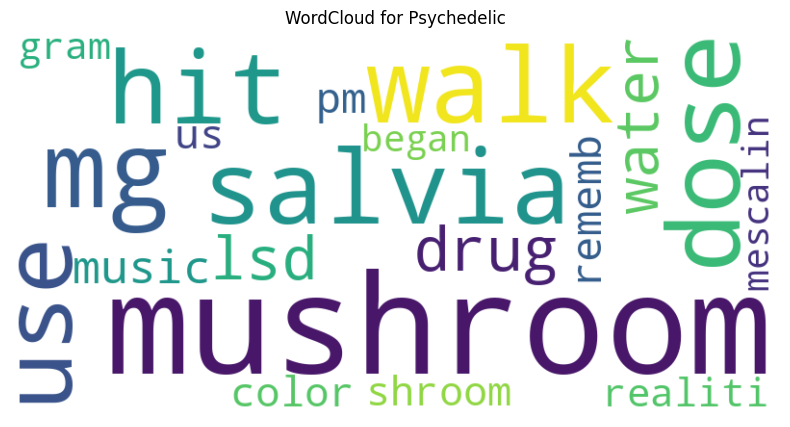

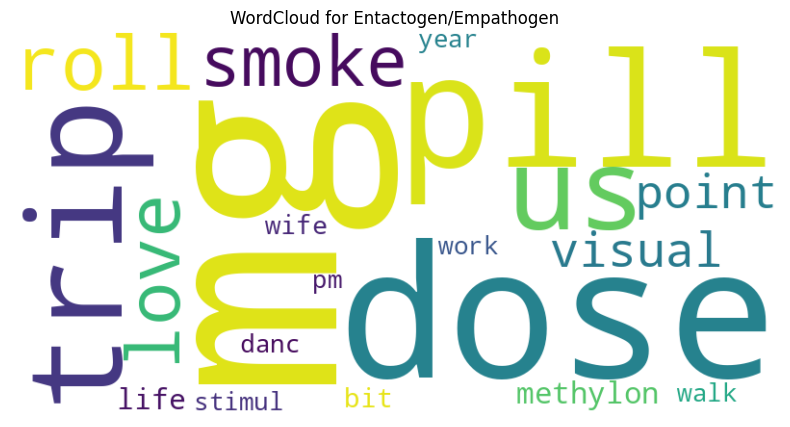

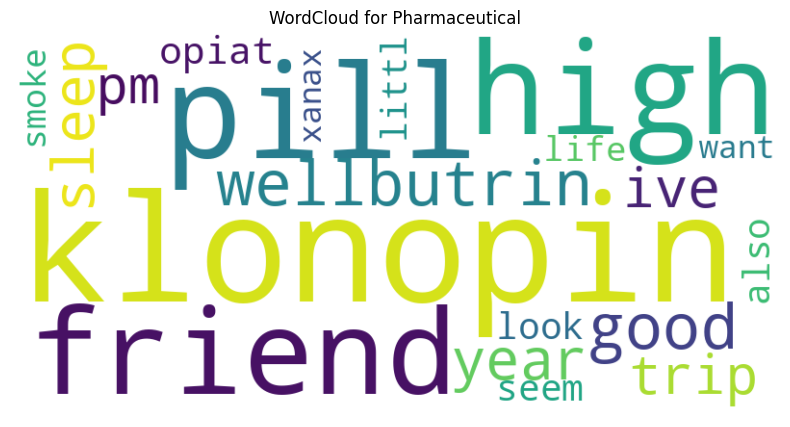

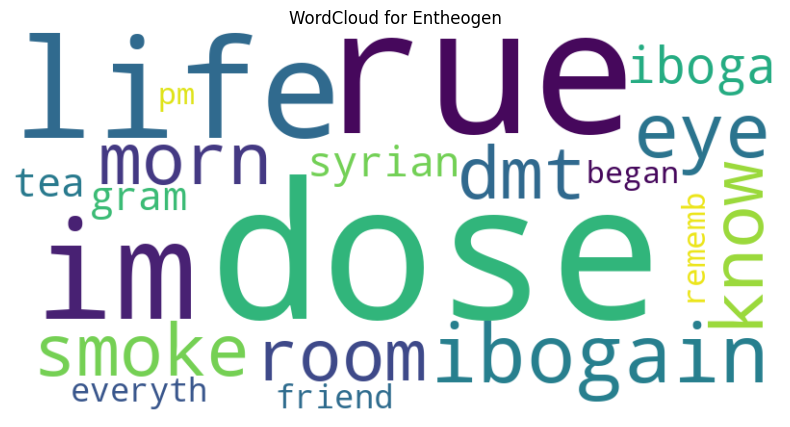

In [ ]:
from collections import Counter

categories = ['Psychedelic', 'Entactogen/Empathogen', 'Pharmaceutical', 'Entheogen']

for category in categories:
    # Filter the dataset based on the category
    subset = df[df['drug_category'] == category]

    # Generate the corpus and dictionary for the subset
    corpus_subset, dictionary_subset = generate_corpus(subset)

    # Apply LDA on the corpus
    lda_subset = LdaModel(corpus=corpus_subset, id2word=dictionary_subset, num_topics=10, passes=10)

    # Create a counter to keep track of word frequencies across topics
    word_counter = Counter()

    # Iterate over the topics
    for i in range(10):
        # Get the top 10 words for the topic and their frequencies
        topic_terms = lda_subset.get_topic_terms(i, 10)
        for id, freq in topic_terms:
            word_counter[dictionary_subset.get(id)] += freq

    # Get the 20 most common words
    common_words = word_counter.most_common(20)

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.title(f"WordCloud for {category}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()